In [89]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [90]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [91]:
NUM_CLASSES = 27

# Dataset reading

In [92]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [93]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [96]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 27)                297       
Total params: 1,367
Trainable params: 1,367
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [98]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [99]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
85/95 [=========================>....] - ETA: 0s - loss: 3.2525 - accuracy: 0.0654
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
95/95 [==============================] - 0s 3ms/step - loss: 3.2430 - accuracy: 0.0698 - val_loss: 3.1157 - val_accuracy: 0.1602
Epoch 2/1000
86/95 [==========================>...] - ETA: 0s - loss: 3.0112 - accuracy: 0.1453
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
95/95 [==============================] - 0s 2ms/step - loss: 2.9987 - accuracy: 0.1476 - val_loss: 2.8236 - val_accuracy: 0.1768
Epoch 3/1000
89/95 [===========================>..] - ETA: 0s - loss: 2.8403 - accuracy: 0.1728
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
95/95 [==============================] - 0s 2ms/step - loss: 2.8353 - accuracy: 0.1738 - val_loss: 2.6565 - val_accuracy: 0.2162
Epoch 4/1000
86/95 [==========================>...] - ETA: 0s - loss: 2.7259 - accura

In [100]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

32/32 [==============================] - 0s 845us/step - loss: 0.9757 - accuracy: 0.7682


In [101]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [102]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.7281385e-05 6.1641564e-10 1.7077592e-21 4.5374288e-10 1.5179193e-17
 1.6655248e-14 4.0547440e-11 3.0201043e-08 1.0432505e-04 4.7753820e-13
 5.8031613e-08 9.2477481e-20 3.0014509e-09 7.4364819e-18 2.6643374e-16
 1.3916991e-10 5.0776333e-01 3.6541653e-01 5.2796842e-30 4.6835593e-22
 5.3353798e-31 8.7611786e-26 4.9809630e-23 4.9989549e-29 1.5380032e-19
 2.3264515e-06 1.2667610e-01]
16


# Confusion matrix

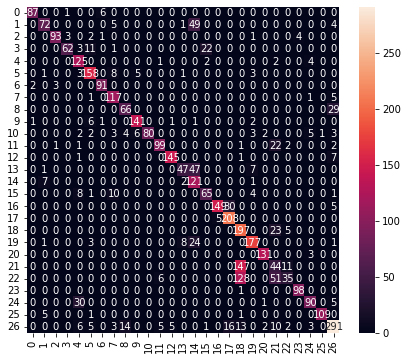

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        94
           1       0.83      0.55      0.66       131
           2       0.96      0.89      0.93       104
           3       0.94      0.63      0.75        99
           4       0.70      0.93      0.80       134
           5       0.83      0.88      0.86       179
           6       0.92      0.95      0.93        96
           7       0.80      0.94      0.86       124
           8       0.79      0.69      0.74        95
           9       0.93      0.92      0.92       153
          10       1.00      0.72      0.84       111
          11       0.89      0.77      0.83       128
          12       0.96      0.94      0.95       154
          13       0.80      0.46      0.58       102
          14       0.50      0.92      0.65       131
          15       0.72      0.73      0.73        89
          16       0.97      0.81      0.88       184
     

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [104]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [105]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmpnhqqnrdt\assets


INFO:tensorflow:Assets written to: C:\Users\WONGCH~1\AppData\Local\Temp\tmpnhqqnrdt\assets


7344

# Inference test

In [106]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [107]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [108]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [109]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [110]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.7281308e-05 6.1641436e-10 1.7077590e-21 4.5374282e-10 1.5179191e-17
 1.6655214e-14 4.0547357e-11 3.0201040e-08 1.0432524e-04 4.7753815e-13
 5.8031549e-08 9.2477474e-20 3.0014620e-09 7.4365092e-18 2.6643270e-16
 1.3916988e-10 5.0776327e-01 3.6541647e-01 5.2796834e-30 4.6835583e-22
 5.3354198e-31 8.7611780e-26 4.9809624e-23 4.9989543e-29 1.5380030e-19
 2.3264470e-06 1.2667622e-01]
16
